In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle #a tool that allows you to save in binary format that saves space
import cmocean
import json
import f90nml
from collections import OrderedDict

fs=16
mpl.rc('xtick', labelsize=fs) #changes some defaults on fault sizes
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)

mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [2]:
year=2009
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [3]:
display(Markdown('''## Year: '''+ str(year)))

## Year: 2009

In [4]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

### load observations

In [5]:
dfSta=pickle.load(open(os.path.join(datadir,'sta_df.p'),'rb')) #opens file and extracts pandas dataframe stored in it and put it in the dataframe

In [6]:
dfSta.head() #shows beginning of the dataframe

,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude
Station,,,,,,
ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933
ADM002,C,Admiralty Inlet (north) - Quimper Pn.,Admiralty Inlet,79,48.187318,-122.842950
ADM003,C,Admiralty Inlet (south),Admiralty Inlet,118,47.878983,-122.483195
BLL009,C,Bellingham Bay - Pt. Frances,Strait of Georgia,31,48.685940,-122.599618
BUD005,C,Budd Inlet - Olympia Shoal,South Basin,22,47.092040,-122.918197


In [7]:
dfBot=pickle.load(open(os.path.join(datadir,f'Bottles_{str(year)}.p'),'rb')) #automatically chooses the right separator for different paths

In [8]:
dfBot.head()

,Station,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,2009-04-06,2009-04-06 19:02:00,-29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,2009-04-06,2009-04-06 19:02:00,-9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,2009-04-06,2009-04-06 19:02:00,-1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,2009-05-20,2009-05-20 19:35:00,-29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,2009-05-20,2009-05-20 19:35:00,-9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [9]:
df1=pd.merge(left=dfSta,right=dfBot,how='right',
             left_on='Station',right_on='Station') #tells you the column names to look at
#right join means all rows in right table (dfBot) are included in output
df1.head()

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,-1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,-29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,-9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [10]:
#check that there are no stations without lat and lon:
df1.loc[pd.isnull(df1['Latitude'])]

,Station,Desig,Descrip,Basin,Max_Depth,Latitude,Longitude,Date,UTCDateTime,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom


In [11]:
# check one to one matches for row numbers in each table:
len(df1),len(dfBot),len(dfSta)

(571, 571, 39)

In [12]:
# We require the following columns:
#    dtUTC datetime
#    Lat   Latitude
#    Lon   Longitude
#    Z     Depth, increasing downward (positive)
df1.rename(columns={'UTCDateTime':'dtUTC','Latitude':'Lat','Longitude':'Lon'},inplace=True)
df1['Z']=-1*df1['Z'] #changing Parker's negative depth values to positive values
df1.head()

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Date,dtUTC,Z,PO4(uM)D,SiOH4(uM)D,NO3(uM)D,NO2(uM)D,NH4(uM)D,DIN,Znom
0,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,29.737,2.326720,54.957096,26.395241,0.420664,0.994396,27.810301,-30.0
1,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,9.866,2.329884,54.869972,26.359756,0.427531,0.887487,27.674774,-10.0
2,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-04-06,2009-04-06 19:02:00,1.014,2.321841,55.717751,26.358368,0.424185,0.767900,27.550453,-0.0
3,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,29.652,1.857458,43.407459,17.997786,0.340660,2.840845,21.179290,-30.0
4,ADM001,C,Admiralty Inlet - Bush Pt.,Admiralty Inlet,114,48.029813,-122.617933,2009-05-20,2009-05-20 19:35:00,9.818,1.412211,44.223774,13.289508,0.283774,1.721990,15.295271,-10.0


In [13]:
# It will also be useful to add/rename the following columns:
df1['NO23']=df1['NO3(uM)D']+df1['NO2(uM)D'] # the model does not distinguish between NO2 and NO3
df1['Amm']=df1['NH4(uM)D']
df1['Si']=df1['SiOH4(uM)D']
df1['Year']=[ii.year for ii in df1['dtUTC']]
df1['YD']=et.datetimeToYD(df1['dtUTC'])

In [14]:
print(len(df1),'data points')
print('Number of data points in each region:')
df1.groupby('Basin')['NO23'].count()

571 data points
Number of data points in each region:


Basin
Admiralty Inlet       72
Grays Harbor          27
Hood Canal Basin      49
Main Basin           109
South Basin          130
Strait of Georgia     58
Whidbey Basin         61
Willapa Bay           65
Name: NO23, dtype: int64

### set up variables for model-data matching

In [15]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)
flen=1 # number of days of model output contained in a single file
namfmt='nowcast' # pretty much always going to be set from nowcast
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T',
         'ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

In [16]:
data=et.matchData(df1,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False);

(Lat,Lon)= 46.54537666666667 -123.98016166666666  not matched to domain
(Lat,Lon)= 46.644 -123.993  not matched to domain
(Lat,Lon)= 46.68676333333333 -123.9735  not matched to domain
(Lat,Lon)= 46.68732166666667 -123.74988166666667  not matched to domain
(Lat,Lon)= 46.703986666666665 -123.837385  not matched to domain
(Lat,Lon)= 46.937313333333336 -123.91322333333333  not matched to domain
(Lat,Lon)= 46.953421666666664 -124.09295  not matched to domain
(Lat,Lon)= 46.97787 -123.78461  not matched to domain
(Lat,Lon)= 47.21342666666666 -123.07765  not matched to domain


In [34]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

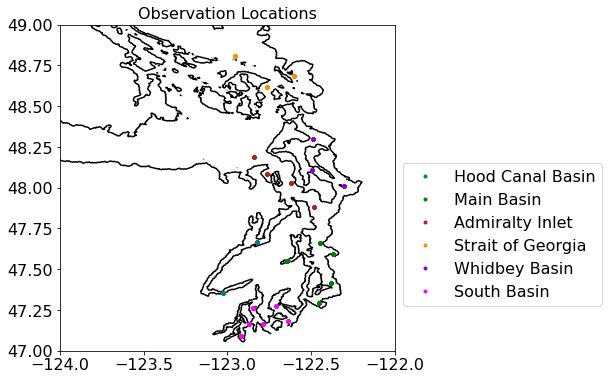

In [35]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
datreg=dict()
for ind, iregion in enumerate(data.Basin.unique()):
    datreg[iregion] = data.loc[data.Basin==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

iz=(data.Z<15)
JFM=data.loc[iz&(data.dtUTC<=dt.datetime(year,4,1)),:]
Apr=data.loc[iz&(data.dtUTC<=dt.datetime(year,5,1))&(data.dtUTC>dt.datetime(year,4,1)),:]
MJJA=data.loc[iz&(data.dtUTC<=dt.datetime(year,9,1))&(data.dtUTC>dt.datetime(year,5,1)),:]
SOND=data.loc[iz&(data.dtUTC>dt.datetime(year,9,1)),:]

In [19]:
def byDepth(ax,obsvar,modvar,lims):
    ps=et.varvarPlot(ax,data,obsvar,modvar,'Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
    l=ax.legend(handles=ps)
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def byRegion(ax,obsvar,modvar,lims):
    ps=[]
    for ind, iregion in enumerate(data.Basin.unique()):
        ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                color = colors[ind], label=iregion)
        ps0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        ps.append(ps0)
    l=ax.legend(handles=[ip[0][0] for ip in ps])
    ax.set_xlabel('Obs')
    ax.set_ylabel('Model')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return ps,l

def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    ps=et.varvarPlot(ax[0],JFM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Jan-Mar')
    ps=et.varvarPlot(ax[1],Apr,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Apr')
    ps=et.varvarPlot(ax[2],MJJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('May-Aug')
    ps=et.varvarPlot(ax[3],SOND,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Sep-Dec')
    return 

def ErrErr(fig,ax,obsvar1,modvar1,obsvar2,modvar2,lims1,lims2):
    m=ax.scatter(data[modvar1]-data[obsvar1],data[modvar2]-data[obsvar2],c=data['Z'],s=1,cmap='gnuplot')
    cb=fig.colorbar(m,ax=ax,label='Depth (m)')
    ax.set_xlim(lims1)
    ax.set_ylim(lims2)
    ax.set_aspect((lims1[1]-lims1[0])/(lims2[1]-lims2[0]))
    return m,cb

In [20]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, JFM':JFM,
                      'z < 15 m, Apr':Apr,
                      'z < 15 m, MJJA':MJJA,
                      'z < 15 m, SOND': SOND,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, JFM', 'z < 15 m, Apr', 'z < 15 m, MJJA', 'z < 15 m, SOND', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'South Basin'])

# Nitrate

In [21]:
obsvar='NO23'
modvar='mod_nitrate'
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, JFM
z < 15 m, Apr
z < 15 m, MJJA
z < 15 m, SOND
Hood Canal Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
South Basin


/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1129: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1130: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


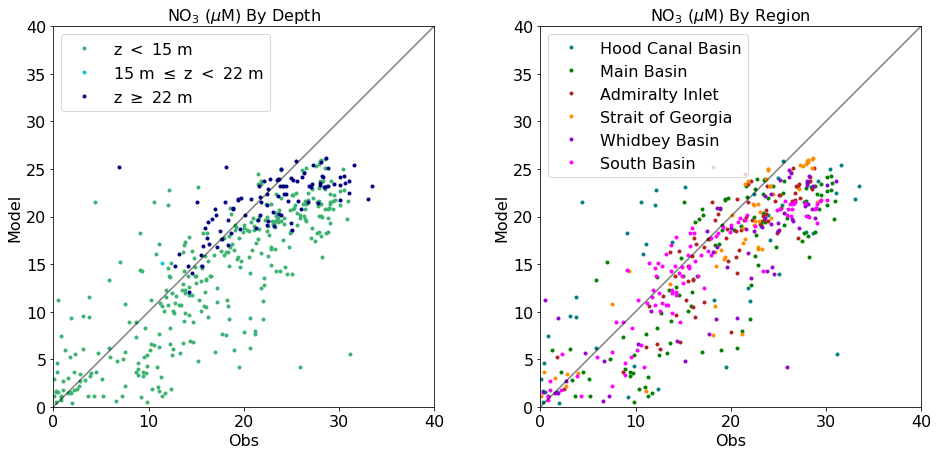

In [22]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

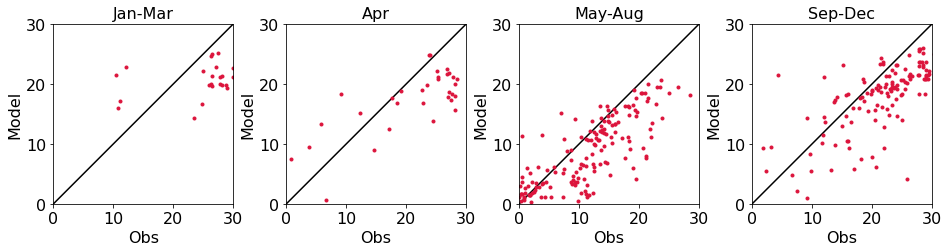

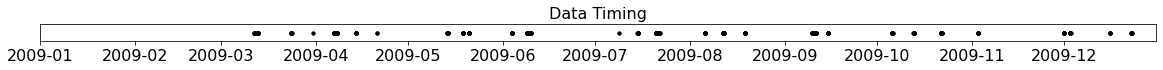

In [23]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,30))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

# Dissolved Silica

In [24]:
obsvar='Si'
modvar='mod_silicon'
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1129: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1130: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


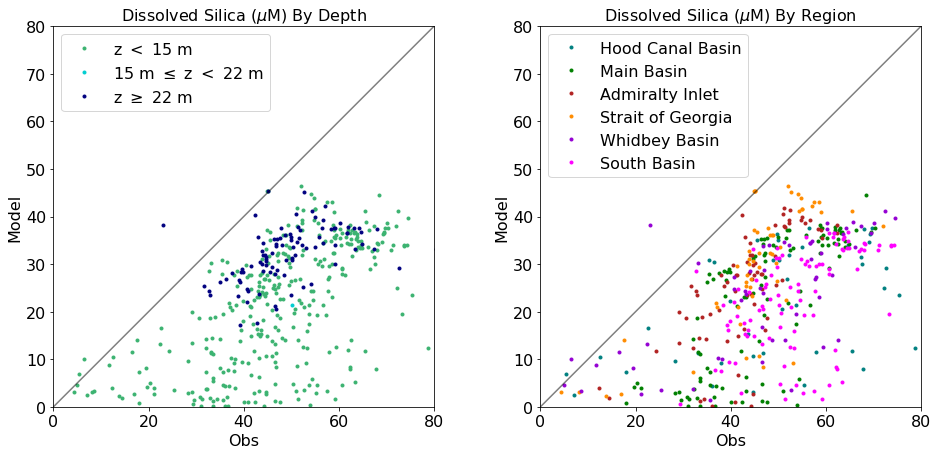

In [25]:
mv=(0,80)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

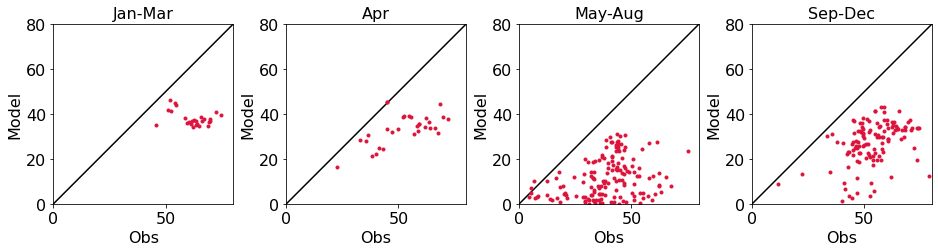

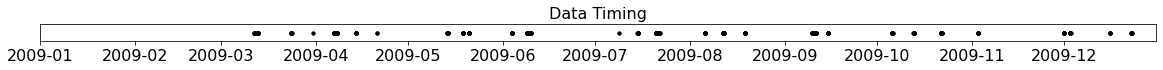

In [26]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,mv)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

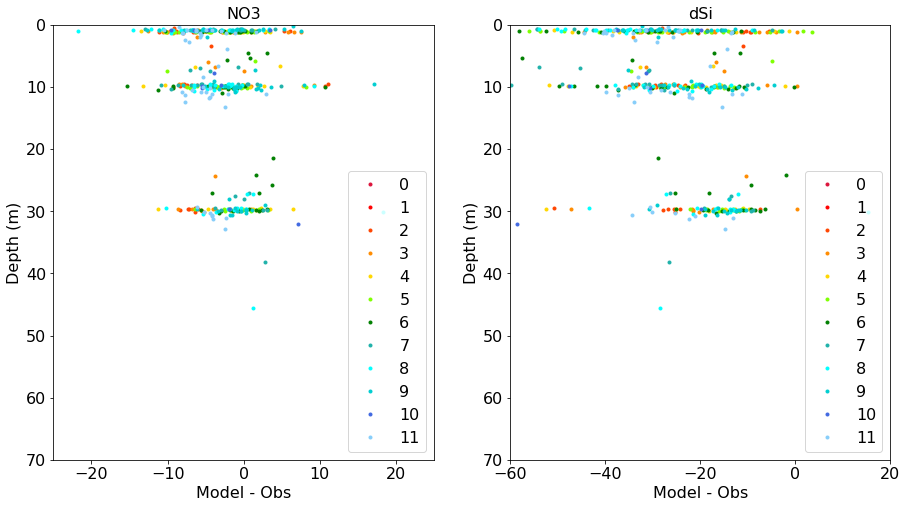

In [27]:
fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

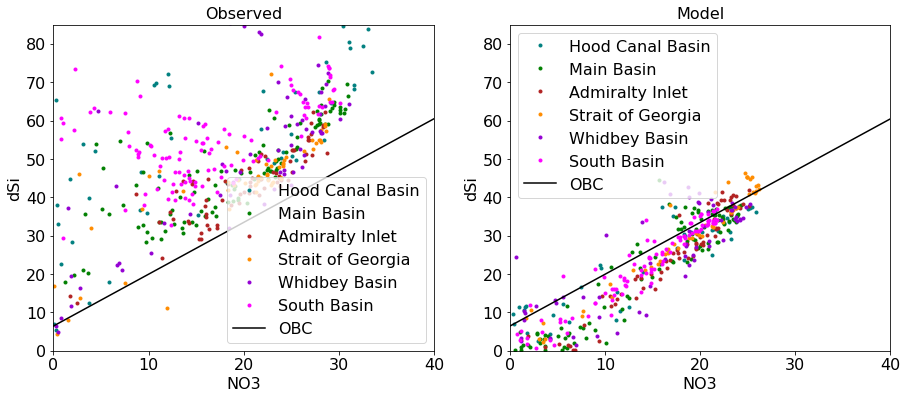

In [28]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

In [29]:
obsvar='Amm'
modvar='mod_ammonium'
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ksuchy/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1129: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/ksuchy/MOAD/tools/SalishSeaTools/salishsea_tools/evaltools.py:1130: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


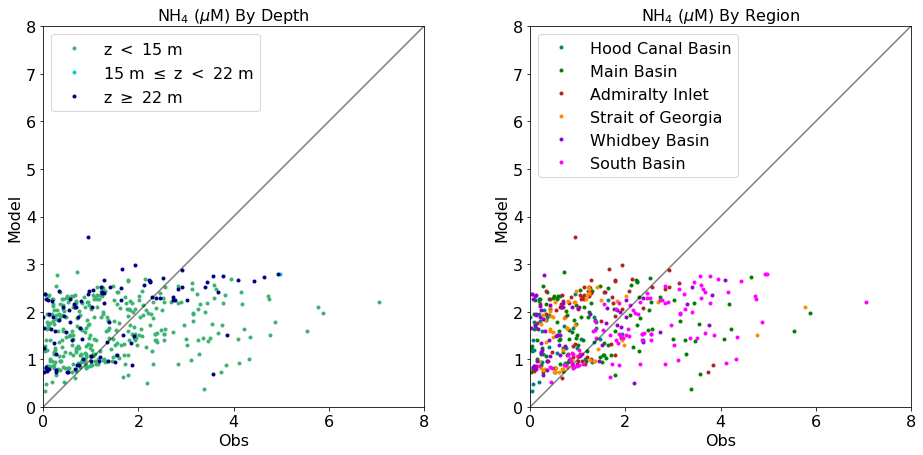

In [30]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=byDepth(ax[0],obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=byRegion(ax[1],obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

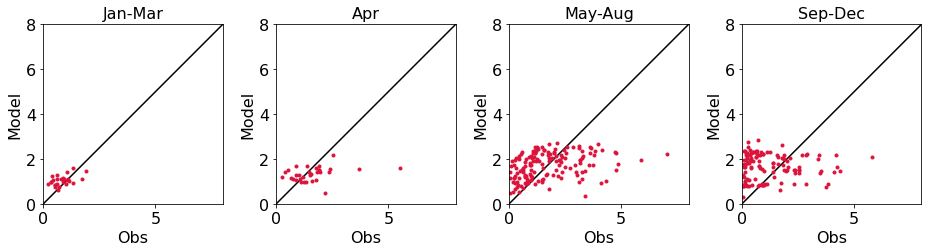

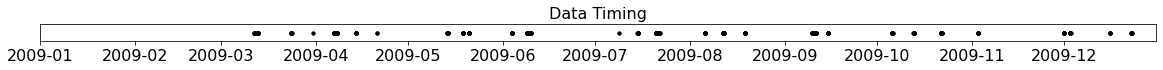

In [31]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,obsvar,modvar,(0,8))
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Does model ammonium depend strongly on model salinity? 
### Does the residual of (model-obs ammonium) depend on model salinity?

In [32]:
data.head()

,Station,Desig,Descrip,Basin,Max_Depth,Lat,Lon,Date,dtUTC,Z,...,i,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_ciliates,mod_flagellates,mod_vosaline,mod_votemper,k
0,HCB004,C,"Hood Canal - Gt. Bend, Sisters Point",Hood Canal Basin,53,47.356205,-123.024873,2009-03-11,2009-03-11 18:30:00,1.042000,...,118,16.012035,37.602016,1.435322,0.409200,0.235496,0.430618,22.323891,6.728588,1
1,HCB004,C,"Hood Canal - Gt. Bend, Sisters Point",Hood Canal Basin,53,47.356205,-123.024873,2009-03-11,2009-03-11 18:30:00,9.877000,...,118,22.817808,34.589394,0.933944,0.138811,0.131530,0.188983,29.412308,10.142488,9
2,HCB004,C,"Hood Canal - Gt. Bend, Sisters Point",Hood Canal Basin,53,47.356205,-123.024873,2009-03-11,2009-03-11 18:30:00,40.509998,...,118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,HCB010,C,"Hood Canal - Send Creek, Bangor",Hood Canal Basin,100,47.670000,-122.820000,2009-03-11,2009-03-11 19:34:00,1.039000,...,186,17.139961,35.158241,1.257981,0.574897,0.226047,0.510219,26.557316,6.695756,1
4,HCB010,C,"Hood Canal - Send Creek, Bangor",Hood Canal Basin,100,47.670000,-122.820000,2009-03-11,2009-03-11 19:34:00,9.505000,...,186,21.567041,36.320904,1.006372,0.277864,0.153770,0.314119,29.078060,8.362720,9


In [33]:
data.keys()

Index(['Station', 'Desig', 'Descrip', 'Basin', 'Max_Depth', 'Lat', 'Lon',
       'Date', 'dtUTC', 'Z', 'PO4(uM)D', 'SiOH4(uM)D', 'NO3(uM)D', 'NO2(uM)D',
       'NH4(uM)D', 'DIN', 'Znom', 'NO23', 'Amm', 'Si', 'Year', 'YD', 'j', 'i',
       'mod_nitrate', 'mod_silicon', 'mod_ammonium', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_vosaline', 'mod_votemper', 'k'],
      dtype='object')